In [2]:
import os
import pandas
import zipfile
import urllib.request
import plotnine
from subprocess import Popen

In [3]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

## Скачаем данные

### Скачаем архив

In [4]:
data_url = "http://www.russiangenome.ru/biengi.zip"
data_zip = os.path.join(data_dir, "plink_data.zip")

urllib.request.urlretrieve(data_url, data_zip)

('data/plink_data.zip', <http.client.HTTPMessage at 0x7efd2b8ec790>)

### Распакуем архив

In [5]:
with zipfile.ZipFile(data_zip, 'r') as zipped_datafile:
    zipped_datafile.extractall(data_dir)

### Получим путь к данным

In [6]:
data_prefix = [os.path.splitext(os.path.join(data_dir, file))[0] for file in os.listdir(data_dir) if file.endswith('.bed')][0]

## Скачаем plink

In [8]:
%%bash
URL64BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20200121.zip"
URL32BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_i686_20200121.zip"

# Измените версию если нужно
URL=$URL64BIT

wget -q $URL -O plink.zip
unzip -q -n plink.zip plink

## Определим функции для работы с plink

In [16]:
def prune_data(plink_prefix, out_prefix): 
    cmd = ['/content/plink', '--bfile', plink_prefix, #указываем файл, который идёт на вход
           '--indep', '50', '5', '2', '--out', out_prefix #указываем, что хотим получить независимые позиции
    ]
    prune_result = out_prefix + '.prune.in' 
    assert Popen(cmd).wait() == 0

    cmd = ['/content/plink', '--bfile', plink_prefix, '--extract', prune_result, #оставляем только отфильтрованные позиции
           '--make-bed', '--out', out_prefix #сохраняем
    ]
    assert Popen(cmd).wait() == 0

    return 

def pca_plink(plink_prefix, out_prefix, n_components=20): #получаем pca с помощью plink
    cmd = ['/content/plink', '--pca', str(n_components), '--autosome'] #считаем только по аутосомам
    cmd += ['--bfile', plink_prefix, '--out', out_prefix]

    assert Popen(cmd).wait() == 0

    return out_prefix + '.eigenvec', out_prefix + '.eigenval'

def plot_pca(df, dim=2):  #просто отрисовываем
    size=5
    symbol='cicle',
    opacity=1.
    if dim == 2:
        scatter = go.Scatter(
            visible=True,
            name=name,
            x=df.loc[:, 0],
            y=df.loc[:, 1],
            text=[(name, indiv) for _, indiv in zip(
                range(df.loc[:, cols[0]].shape[0]), point_names)],
            textposition='middle right',
            mode='markers',
            marker=dict(size=size, opacity=opacity, symbol=symbol))
    elif dim == 3:
        scatter = go.Scatter3d(
            visible=True,
            name=name,
            x=df.loc[:, 0],
            y=df.loc[:, 1],
            z=df.loc[:, 2],
            text=[(name, indiv) for _, indiv in zip(
                range(df.loc[:, cols[0]].shape[0]), point_names)],
            textposition='middle right',
            mode='markers',
            marker=dict(size=size, opacity=opacity, symbol=symbol))
    return scatter


# Посторим PCA

## Запустим прунинг

In [17]:
pruned_data = data_prefix + '_pruned'
prune_data(data_prefix, pruned_data)

## Запустим PCA

In [18]:
pca_prefix = pruned_data + '_pruned'
pca_eigenvec, pca_eigenval = pca_plink(pruned_data, pca_prefix)

## Нарисуем PCA

### Прочитаем популяции

In [19]:
pop_filename = data_prefix + ".pedind"
pop_df = pandas.read_csv(pop_filename, sep="\s+", header=None, usecols = [0, 1, 5],
                        names=['FID', 'IID', 'Population'])

pop_df.head()

,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


### Прочитаем результаты PCA

In [23]:
eigenvec_df = pandas.read_csv(pca_eigenvec, sep="\s+", header=None)
eigenvec_df.head()
#первые две колонки - названия образцов, а дальше координаты по каждой из осей

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [43]:
merge_df = pandas.merge(eigenvec_df, pop_df, left_on=[0, 1], right_on=['FID', 'IID'])
merge_df = merge_df.drop(columns=[0,1])
merge_df.rename(columns={ merge_df.columns[0]: "pc1",
                          merge_df.columns[1]: "pc2", 
                          merge_df.columns[2]: "pc3", 
                          merge_df.columns[3]: "pc4", 
                          merge_df.columns[4]: "pc5", 
                          merge_df.columns[5]: "pc6", 
                          merge_df.columns[6]: "pc7", 
                          merge_df.columns[7]: "pc8", 
                          merge_df.columns[8]: "pc9", 
                          merge_df.columns[9]: "pc10", 
                          merge_df.columns[10]: "pc11", 
                          merge_df.columns[11]: "pc12", 
                          merge_df.columns[12]: "pc13", 
                          merge_df.columns[13]: "pc14", 
                          merge_df.columns[14]: "pc15", 
                          merge_df.columns[15]: "pc16", 
                          merge_df.columns[16]: "pc17", 
                          merge_df.columns[17]: "pc18", 
                          merge_df.columns[18]: "pc19", 
                          merge_df.columns[19]: "pc20"}, inplace = True)
merge_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc14,pc15,pc16,pc17,pc18,pc19,pc20,FID,IID,Population
0,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,-0.073206,0.037070,...,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613,4461875510_R01C01,4461875510_R01C01,Karel
1,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,-0.014171,-0.014982,...,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745,4461875510_R01C02,4461875510_R01C02,Karel
2,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,-0.101528,0.038745,...,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078,4461875510_R02C01,4461875510_R02C01,Karel
3,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,-0.090599,0.039748,...,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287,4461875513_R02C02,4461875513_R02C02,Karel
4,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,-0.083010,0.035734,...,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286,4461875513_R01C02,4461875513_R01C02,Karel


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


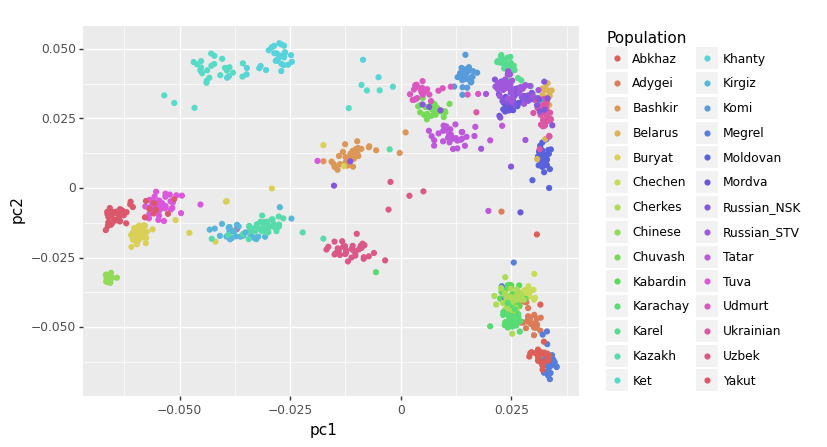

<ggplot: (8726612422625)>

In [25]:
plotnine.ggplot(merge_df) + plotnine.aes(x="pc1", y="pc2", color='Population') + plotnine.geom_point() #меняя компоненты, получаем разный взгляд на срез популяций

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


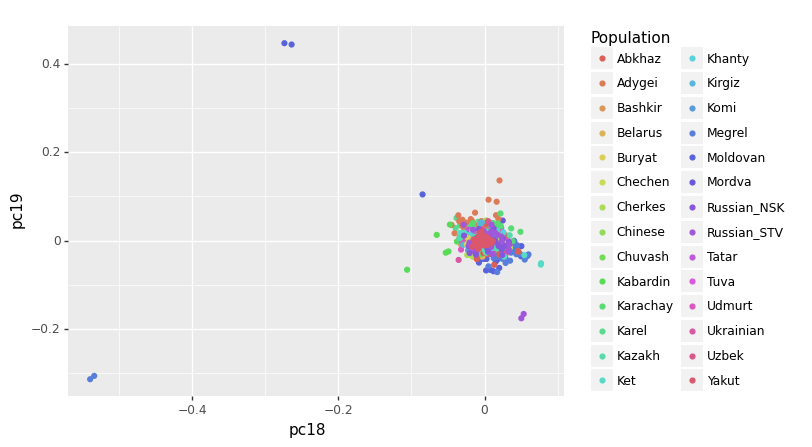

<ggplot: (8726611938233)>

In [44]:
plotnine.ggplot(merge_df) + plotnine.aes(x="pc18", y="pc19", color='Population') + plotnine.geom_point()